C:\Users\athee\AppData\Local\Temp\ipykernel_3744\2650217880.py:169: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)


SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9919
PSNR (Original Image vs. Watermarked Image): 57.9021
MSE (Original Image vs. Watermarked Image): 0.1054


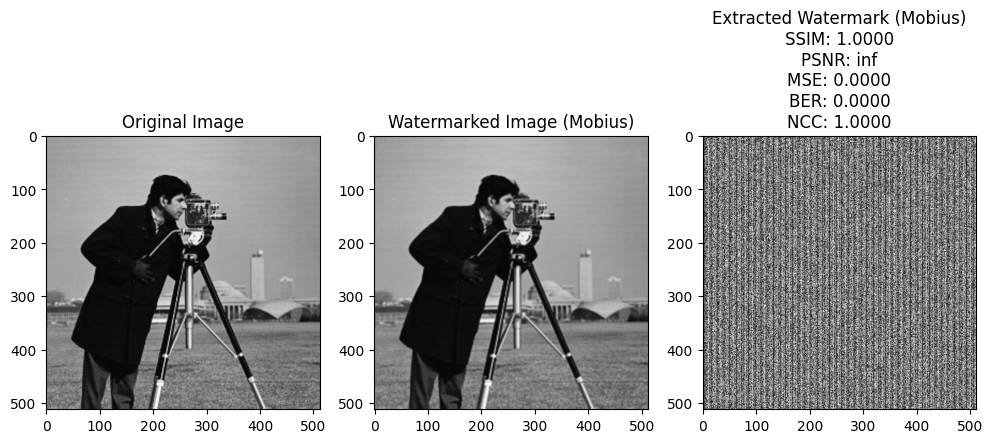

Extracted Watermark (Size 1) saved at: watermarked_image_mobius_extract.png


C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Temp\ipykernel_3744\2650217880.py:169: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)


SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9942
PSNR (Original Image vs. Watermarked Image): 50.1873
MSE (Original Image vs. Watermarked Image): 0.6228


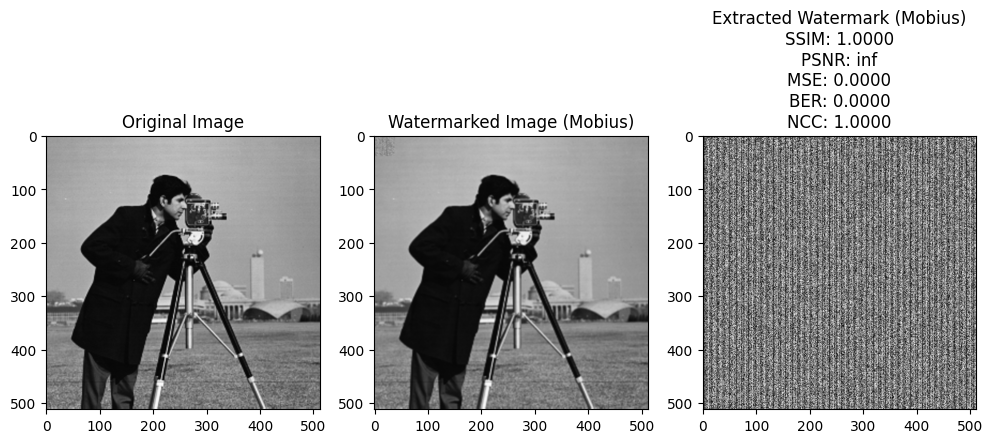

Extracted Watermark (Size 2) saved at: watermarked_image_mobius_extract.png


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms

# Define Mobius transform function
def mobius_transform(x, y, a, b, c, d):
    new_x = (a * x + b) / (c * x + d)
    new_y = (a * y + b) / (c * y + d)
    return new_x, new_y

# Define inverse Mobius transform function
def inverse_mobius_transform(new_x, new_y, a, b, c, d):
    x = (d * new_x - b) / (a - c * new_x)
    y = (d * new_y - b) / (a - c * new_y)
    return x, y

# Define a function to embed watermark in DCT coefficients using Mobius Transform
def embed_watermark_dct_mobius(original_image, watermark, alpha, mobius_params):
    ycbcr_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2YCrCb)
    y_channel = ycbcr_image[:, :, 0].astype(np.float64)

    dct_y = cv2.dct(y_channel)

    watermarked_dct_y = np.copy(dct_y)

    height, width = watermark.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                watermarked_dct_y[int(new_y), int(new_x)] += alpha * watermark[y, x]

    watermarked_image = cv2.idct(watermarked_dct_y)

    watermarked_image = np.clip(watermarked_image, 0, 255)

    watermarked_ycbcr_image = ycbcr_image.copy()
    watermarked_ycbcr_image[:, :, 0] = watermarked_image.astype(np.uint8)

    watermarked_image = cv2.cvtColor(watermarked_ycbcr_image, cv2.COLOR_YCrCb2BGR)

    return watermarked_image

# Define a function to extract watermark from DCT coefficients using Mobius Transform
def extract_watermark_dct_mobius(watermarked_image, original_image, alpha, mobius_params):
    ycbcr_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2YCrCb)
    ycbcr_watermarked = cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2YCrCb)

    y_channel_original = ycbcr_original[:, :, 0].astype(np.float64)
    y_channel_watermarked = ycbcr_watermarked[:, :, 0].astype(np.float64)

    dct_y_original = cv2.dct(y_channel_original)
    dct_y_watermarked = cv2.dct(y_channel_watermarked)

    extracted_watermark = np.zeros_like(dct_y_original)

    height, width = extracted_watermark.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                extracted_watermark[y, x] = (dct_y_watermarked[y, x] - dct_y_original[y, x]) / alpha

    return extracted_watermark

# Define a function to calculate Bit Error Rate (BER)
def calculate_ber(original_watermark, extracted_watermark):
    num_errors = np.sum(original_watermark != extracted_watermark)
    total_bits = original_watermark.size
    ber = num_errors / total_bits
    return ber

# Define a function to calculate Normalized Cross-Correlation (NCC)
def calculate_ncc(original_watermark, extracted_watermark):
    original_watermark = (original_watermark - np.mean(original_watermark)) / np.std(original_watermark)
    extracted_watermark = (extracted_watermark - np.mean(extracted_watermark)) / np.std(extracted_watermark)
    ncc = np.sum(original_watermark * extracted_watermark) / original_watermark.size
    return ncc

# Define a function to optimize Mobius transform parameters using Genetic algorithm
def optimize_mobius_parameters_DEAP(original_image, watermark_image):
    height, width = watermark_image.shape[:2]

    def fitness(params):
        a, b, c, d = params
        extracted_watermark = np.zeros_like(watermark_image)

        for y in range(height):
            for x in range(width):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < width and 0 <= new_y < height:
                    extracted_watermark[int(new_y), int(new_x)] = watermark_image[y, x]

        ssim_value = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark.max() - extracted_watermark.min())
        return ssim_value,

    creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -10.0, 10.0)
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_float,), n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
    toolbox.register("select", tools.selBest)

    population_size = 50
    generations = 20
    population = toolbox.population(n=population_size)

    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=population_size)

    best_ind = tools.selBest(population, k=1)[0]
    return best_ind

# Function to process an image with watermark using Mobius Transform
def process_image_mobius(input_image_path, watermark_image_path, mobius_params, fake_disappear=False):
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    watermark_image = cv2.imread(watermark_image_path, cv2.IMREAD_COLOR)

    if watermark_image is None:
        raise Exception(f"Failed to load watermark image from '{watermark_image_path}'")

    watermark_image = cv2.resize(watermark_image, (original_image.shape[1], original_image.shape[0]))

    watermarked_image_mobius = np.copy(original_image)

    if mobius_params is not None:
        a, b, c, d = mobius_params

        for y in range(original_image.shape[0]):
            for x in range(original_image.shape[1]):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                    watermarked_image_mobius[int(new_y), int(new_x)] = watermark_image[y, x]

    extracted_watermark_mobius = np.zeros_like(watermark_image)

    for y in range(original_image.shape[0]):
        for x in range(original_image.shape[1]):
            new_x, new_y = inverse_mobius_transform(x, y, 1.0, 0.0, 0.0, 1.0)

            if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                extracted_watermark_mobius[y, x] = watermark_image[int(new_y), int(new_x)]

    ssim_mobius = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark_mobius.max() - extracted_watermark_mobius.min())
    mse_mobius_watermark = mean_squared_error(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)

    ssim_image = ssim(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY), data_range=watermarked_image_mobius.max() - watermarked_image_mobius.min())
    mse_mobius_image = mean_squared_error(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_image = 10 * np.log10((255**2) / mse_mobius_image)

    ber_mobius_watermark = calculate_ber(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    ncc_mobius_watermark = calculate_ncc(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))

    print(f"SSIM (Original Watermark vs. Extracted Watermark): {ssim_mobius:.4f}")
    print(f"PSNR (Original Watermark vs. Extracted Watermark): {psnr_mobius_watermark:.4f}")
    print(f"MSE (Original Watermark vs. Extracted Watermark): {mse_mobius_watermark:.4f}")
    print(f"BER (Original Watermark vs. Extracted Watermark): {ber_mobius_watermark:.4f}")
    print(f"NCC (Original Watermark vs. Extracted Watermark): {ncc_mobius_watermark:.4f}")

    print(f"SSIM (Original Image vs. Watermarked Image): {ssim_image:.4f}")
    print(f"PSNR (Original Image vs. Watermarked Image): {psnr_mobius_image:.4f}")
    print(f"MSE (Original Image vs. Watermarked Image): {mse_mobius_image:.4f}")

    if fake_disappear:
        alpha = 0.3
        watermarked_image_mobius = cv2.addWeighted(watermarked_image_mobius, alpha, original_image, 1 - alpha, 0)

    kernel_size = (3, 3)
    watermarked_image_mobius = cv2.GaussianBlur(watermarked_image_mobius, kernel_size, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(132), plt.imshow(cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2RGB)), plt.title('Watermarked Image (Mobius)')
    plt.subplot(133), plt.imshow(cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2RGB)), plt.title(f'Extracted Watermark (Mobius)\nSSIM: {ssim_mobius:.4f}\nPSNR: {psnr_mobius_watermark:.4f}\nMSE: {mse_mobius_watermark:.4f}\nBER: {ber_mobius_watermark:.4f}\nNCC: {ncc_mobius_watermark:.4f}')
    plt.show()

    extracted_watermark_mobius_path = 'watermarked_image_mobius_extract.png'
    cv2.imwrite(extracted_watermark_mobius_path, cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))

    return extracted_watermark_mobius_path

# Load the medical image
image_path = 'cameraman.tif'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Define the paths to the watermarks of two different sizes
watermark_path_1 = 'watermark_image.png'

desired_size_original = (256, 256)
resized_original_image = cv2.resize(original_image, desired_size_original)

desired_size_watermark_1 = (32, 32)
resized_watermark_1 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_1)

desired_size_watermark_2 = (256, 256)
resized_watermark_2 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_2)

optimized_params_1 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_1)

if optimized_params_1 is not None:
    extracted_watermark_path_1 = process_image_mobius(image_path, watermark_path_1, optimized_params_1, fake_disappear=True)
    print(f"Extracted Watermark (Size 1) saved at: {extracted_watermark_path_1}")
else:
    print("Optimization for Watermark (Size 1) did not converge to a solution.")

optimized_params_2 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_2)

if optimized_params_2 is not None:
    extracted_watermark_path_2 = process_image_mobius(image_path, watermark_path_1, optimized_params_2, fake_disappear=True)
    print(f"Extracted Watermark (Size 2) saved at: {extracted_watermark_path_2}")
else:
    print("Optimization for Watermark (Size 2) did not converge to a solution.")
